### Imports + functions from previous labs

In [1]:
import os
import sys
import json
import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
from scipy.ndimage import gaussian_filter
import tensorflow as tf

sys.path.insert(0, '../')
print(f"TensorFlow version: {tf.__version__}")

c:\Users\Marie\anaconda3\envs\msinet_saliency_env\lib\site-packages\tensorflow\python\framework\dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
c:\Users\Marie\anaconda3\envs\msinet_saliency_env\lib\site-packages\tensorflow\python\framework\dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
c:\Users\Marie\anaconda3\envs\msinet_saliency_env\lib\site-packages\tensorflow\python\framework\dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
c:\Users\Marie\anaconda3\envs\m

TensorFlow version: 1.13.1


In [2]:
PATH_DATA = "../IRCCyN_IVC_Eyetracker_Berkeley_Database"
RESO_X = 1280
RESO_Y = 1024
FACTOR_X = RESO_X / 338
FACTOR_Y = RESO_Y / 270
IMAGE_LIST = [1, 2, 5, 7, 10, 14, 21, 27, 37, 44]
#IMAGE_LIST = [1, 2, 7, 10, 14]
MODELS_TO_TEST = ['salicon', 'mit1003', 'cat2000', 'osie']

print(f"Dataset path: {PATH_DATA}")
print(f"Images to test: {IMAGE_LIST}")
print(f"Models to test: {MODELS_TO_TEST}")

Dataset path: ../IRCCyN_IVC_Eyetracker_Berkeley_Database
Images to test: [1, 2, 5, 7, 10, 14, 21, 27, 37, 44]
Models to test: ['salicon', 'mit1003', 'cat2000', 'osie']


In [3]:
def range_normalize(x):
    """Normalizes x to [0, 1]"""
    if x.max() == x.min():
        return np.zeros_like(x)
    return (x - x.min()) / (x.max() - x.min())

def sum_normalize(x):
    """Normalizes x so that it sums to 1"""
    if x.sum() == 0:
        return x
    return x / x.sum()

def std_normalize(x):
    """Standardizes x"""
    std = np.std(x)
    if std == 0:
        return np.zeros_like(x)
    return (x - np.mean(x)) / std

def log_density(saliencyMap, eps=np.spacing(1.0)):
    """Transforms a non probabilistic saliency map into a log density"""
    saliencyMap = saliencyMap - saliencyMap.min()
    saliencyMap += eps
    saliencyMap /= saliencyMap.sum()
    return np.log(saliencyMap)

In [4]:
def AUC_Judd(saliencyMap, fixationMap, jitter=True):
    """AUC Judd Implementation"""
    if not np.shape(saliencyMap) == np.shape(fixationMap):
        saliencyMap = cv2.resize(saliencyMap, np.shape(fixationMap)[:2][::-1])

    if jitter:
        saliencyMap = saliencyMap + np.random.random(np.shape(saliencyMap)) / 10**7

    saliencyMap = range_normalize(saliencyMap)

    if np.isnan(saliencyMap).all():
        return float('nan')

    S = saliencyMap.flatten()
    F = fixationMap.flatten()
    Sth = S[F > 0]
    Nfixations = len(Sth)
    Npixels = len(S)
    allthreshes = sorted(Sth, reverse=True)

    tpr = np.zeros((Nfixations + 2))
    fpr = np.zeros((Nfixations + 2))
    tpr[0], tpr[-1] = 0, 1
    fpr[0], fpr[-1] = 0, 1

    for i in range(Nfixations):
        thresh = allthreshes[i]
        aboveth = (S >= thresh).sum()
        tpr[i + 1] = float(i + 1) / Nfixations
        fpr[i + 1] = float(aboveth - i) / (Npixels - Nfixations)

    score = np.trapz(tpr, x=fpr)
    return score

def CC(saliencyMap1, saliencyMap2):
    """Correlation Coefficient"""
    if saliencyMap1.shape != saliencyMap2.shape:
        saliencyMap1 = cv2.resize(saliencyMap1, saliencyMap2.shape[:2][::-1])
    saliencyMap1 = std_normalize(saliencyMap1)
    saliencyMap2 = std_normalize(saliencyMap2)
    return np.corrcoef(saliencyMap1.reshape(-1), saliencyMap2.reshape(-1))[0, 1]

def KL_divergence(saliencyMap, baselineMap, eps=np.spacing(1.0)):
    """KL Divergence"""
    if saliencyMap.shape != baselineMap.shape:
        saliencyMap = cv2.resize(saliencyMap, baselineMap.shape[:2][::-1])
    if saliencyMap.any():
        saliencyMap = sum_normalize(saliencyMap)
    if baselineMap.any():
        baselineMap = sum_normalize(baselineMap)
    logp_model = np.log(saliencyMap + eps)
    logp_gt = np.log(baselineMap + eps)
    score = baselineMap * (logp_gt - logp_model)
    return score.sum()

def NSS(saliencyMap, fixationMap):
    """Normalized Scanpath Saliency"""
    if saliencyMap.shape != fixationMap.shape:
        saliencyMap = cv2.resize(saliencyMap, fixationMap.shape[:2][::-1])
    saliencyMap = np.exp(log_density(saliencyMap))
    mean = saliencyMap.mean()
    std = saliencyMap.std()
    value = saliencyMap[fixationMap.astype(bool)]
    if len(value) == 0:
        return np.nan
    value -= mean
    value /= std
    return value.mean()

def similarity(pred_sal, gt_sal):
    """Similarity (Histogram Intersection)"""
    if pred_sal.shape != gt_sal.shape:
        pred_sal = cv2.resize(pred_sal, gt_sal.shape[:2][::-1])
    if pred_sal.any():
        pred_sal = range_normalize(pred_sal)
        pred_sal = sum_normalize(pred_sal)
    if gt_sal.any():
        gt_sal = range_normalize(gt_sal)
        gt_sal = sum_normalize(gt_sal)
    diff = np.minimum(pred_sal, gt_sal)
    return np.sum(diff)

print("Metric functions defined")

Metric functions defined


In [5]:
def get_files_all_observers(dir_path, img_name):
    """List all eye-tracking files for an image"""
    list_all_files = glob.glob(os.path.join(dir_path, 'Eyetracker_Data/**/*' + img_name + '.*'), recursive=True)
    if not list_all_files:
        return None
    return list_all_files

def create_fixmap(list_obs_files, img_w, img_h, factor_x, factor_y, t_begin=0, t_end=15):
    """Create fixation map from eye-tracking data"""
    fixmap = np.zeros((img_h, img_w))
    if not list_obs_files:
        return fixmap
    for obs in list_obs_files:
        try:
            df = pd.read_csv(obs, sep=',', skiprows=19)
            df = df[(df["TimeStamp"] >= t_begin*1000) & (df["TimeStamp"] <= t_end*1000)]
            df = df[df["Tracked"] == 1]
            fix_groups = df.groupby((df["Fixation"].shift() != df["Fixation"]).cumsum())
            for n_group, group in fix_groups:
                if group["Fixation"].all() != 0:
                    x = group["ScreenPositionXmm"].mean() * 0.9
                    y = -group["ScreenPositionYmm"].mean() * 0.9
                    x_pix = int(x * factor_x + img_w / 2)
                    y_pix = int(y * factor_y + img_h / 2)
                    if 0 <= x_pix < img_w and 0 <= y_pix < img_h:
                        fixmap[y_pix, x_pix] += 1
        except:
            pass
    return fixmap

def create_salmap_from_fixmap(fixmap, ppda):
    """Convert fixation map to saliency map via Gaussian blur"""
    salmap = gaussian_filter(fixmap, sigma=ppda)
    return salmap

def compute_ppda(distance, h_res, v_res, screen_w, screen_h):
    """Compute pixels per degree of visual angle"""
    horizontal_ppda = h_res / (2 * np.degrees(np.arctan((screen_w / 2) / distance)))
    vertical_ppda = v_res / (2 * np.degrees(np.arctan((screen_h / 2) / distance)))
    return horizontal_ppda, vertical_ppda

print("Ground-truth functions defined")

Ground-truth functions defined


### Load models

In [6]:
hppda, vppda = compute_ppda(415.8, RESO_X, RESO_Y, 338, 270)
print(f"Pixels per degree: {hppda:.2f}, {vppda:.2f}")

Pixels per degree: 28.93, 28.46


In [7]:
models_sessions = {}
models_tensors = {}

for model_name in MODELS_TO_TEST:
    weights_path = f"./weights/model_{model_name}_cpu.pb"
    
    print(f"\nLoading {model_name.upper()} model from {weights_path}...")
    
    if not os.path.exists(weights_path):
        print(f"  ✗ Weights not found! Skipping...")
        continue
    
    # Load graph
    graph = tf.Graph()
    with graph.as_default():
        graph_def = tf.compat.v1.GraphDef()
        with tf.compat.v1.gfile.GFile(weights_path, 'rb') as f:
            graph_def.ParseFromString(f.read())
        tf.compat.v1.import_graph_def(graph_def, name='')
    
    # Create session
    config = tf.compat.v1.ConfigProto()
    config.gpu_options.allow_growth = True
    sess = tf.compat.v1.Session(graph=graph, config=config)
    
    input_tensor = graph.get_tensor_by_name('input:0')
    output_tensor = graph.get_tensor_by_name('output:0')
    
    models_sessions[model_name] = sess
    models_tensors[model_name] = (input_tensor, output_tensor, graph)
    
    print(f"   {model_name.upper()} loaded")
    print(f"    Input: {input_tensor.shape}")
    print(f"    Output: {output_tensor.shape}")


Loading SALICON model from ./weights/model_salicon_cpu.pb...
   SALICON loaded
    Input: <unknown>
    Output: (?, ?, ?, 1)

Loading MIT1003 model from ./weights/model_mit1003_cpu.pb...
   MIT1003 loaded
    Input: <unknown>
    Output: (?, ?, ?, 1)

Loading CAT2000 model from ./weights/model_cat2000_cpu.pb...
   CAT2000 loaded
    Input: <unknown>
    Output: (?, ?, ?, 1)

Loading OSIE model from ./weights/model_osie_cpu.pb...
   OSIE loaded
    Input: <unknown>
    Output: (?, ?, ?, 1)


### Test the models on our dataset

In [8]:
all_results = {}
all_images = {}

for model_name in models_sessions.keys():
    results_msinet = []
    images_msinet = []
    
    print(f"{model_name.upper()} model on {len(IMAGE_LIST)} images :")
    
    input_tensor, output_tensor, graph = models_tensors[model_name]
    sess = models_sessions[model_name]
    
    for img_num in IMAGE_LIST:
        img_name = f'img.trn.{img_num}.png'
        img_path = os.path.join(PATH_DATA, f"Images/{img_name}")
        
        if not os.path.exists(img_path):
            print(f"  Image {img_num}: NOT FOUND")
            continue
        
        img_bgr = cv2.imread(img_path)
        img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
        height, width = img_rgb.shape[:2]
        
        img_resized = cv2.resize(img_rgb, (224, 224))
        img_float = img_resized.astype(np.float32)
        img_batch = np.expand_dims(img_float, axis=0)
        
        # MSINet saliency map
        msinet_salmap = sess.run(output_tensor, feed_dict={input_tensor: img_batch})
        msinet_salmap = msinet_salmap[0, :, :, 0]  # Remove batch and channel dims
        msinet_salmap = cv2.resize(msinet_salmap, (width, height))  # Resize back
        msinet_salmap = range_normalize(msinet_salmap)
        
        # Ground-truth saliency map
        list_files = get_files_all_observers(PATH_DATA, img_name + '-obs_Obs1')
        if list_files is None:
            print(f"  Image {img_num}: NO GT DATA")
            continue
        
        fixmap_gt = create_fixmap(list_files, 481, 321, FACTOR_X, FACTOR_Y)
        gt_salmap = create_salmap_from_fixmap(fixmap_gt, hppda)
        gt_salmap_resized = cv2.resize(gt_salmap, (width, height))
        
        judd = AUC_Judd(msinet_salmap, fixmap_gt)
        cc = CC(msinet_salmap, gt_salmap_resized)
        kl = KL_divergence(msinet_salmap, gt_salmap_resized)
        sim = similarity(msinet_salmap, gt_salmap_resized)
        
        fixmap_binary = (fixmap_gt > 0).astype(float)
        fixmap_binary_resized = cv2.resize(fixmap_binary, (width, height))
        nss = NSS(msinet_salmap, fixmap_binary_resized)
        
        results_msinet.append({
            'Image': img_num,
            'AUC_Judd': judd,
            'CC': cc,
            'KL': kl,
            'SIM': sim,
            'NSS': nss
        })
        
        images_msinet.append({
            'Image': img_num,
            'img': img_rgb,
            'fixmap': fixmap_gt,
            'salmap_gt': gt_salmap_resized,
            'salmap_msinet': msinet_salmap
        })
        
        print(f"  Image {img_num}: CC={cc:.4f}, KL={kl:.4f}, SIM={sim:.4f}, NSS={nss:.4f}")
    
    all_results[model_name] = results_msinet
    all_images[model_name] = images_msinet
    print(f"\n {model_name.upper()} done")

SALICON model on 10 images :
  Image 1: CC=0.5852, KL=1.4960, SIM=0.5090, NSS=1.8368
  Image 2: CC=0.4330, KL=0.9630, SIM=0.5596, NSS=0.5683
  Image 5: CC=0.9419, KL=0.5725, SIM=0.7653, NSS=2.4723
  Image 7: CC=0.8852, KL=0.1703, SIM=0.7769, NSS=3.1563
  Image 10: CC=0.6977, KL=1.3920, SIM=0.5177, NSS=2.5197
  Image 14: CC=0.5331, KL=1.9499, SIM=0.4458, NSS=1.0246
  Image 21: CC=0.8339, KL=1.2307, SIM=0.6115, NSS=2.5697
  Image 27: CC=0.4935, KL=1.0446, SIM=0.5387, NSS=1.1278
  Image 37: CC=0.7825, KL=0.3059, SIM=0.7170, NSS=1.6835
  Image 44: CC=0.2999, KL=1.0015, SIM=0.5273, NSS=0.5366

 SALICON done
MIT1003 model on 10 images :
  Image 1: CC=0.5124, KL=1.1904, SIM=0.4754, NSS=1.5575
  Image 2: CC=0.5036, KL=0.8513, SIM=0.5660, NSS=0.6752
  Image 5: CC=0.8671, KL=0.7564, SIM=0.6226, NSS=2.7026
  Image 7: CC=0.8179, KL=0.3874, SIM=0.6769, NSS=3.3462
  Image 10: CC=0.8529, KL=1.0681, SIM=0.6381, NSS=3.2723
  Image 14: CC=0.3766, KL=2.3897, SIM=0.3276, NSS=0.6153
  Image 21: CC=0.8049, 

### plots

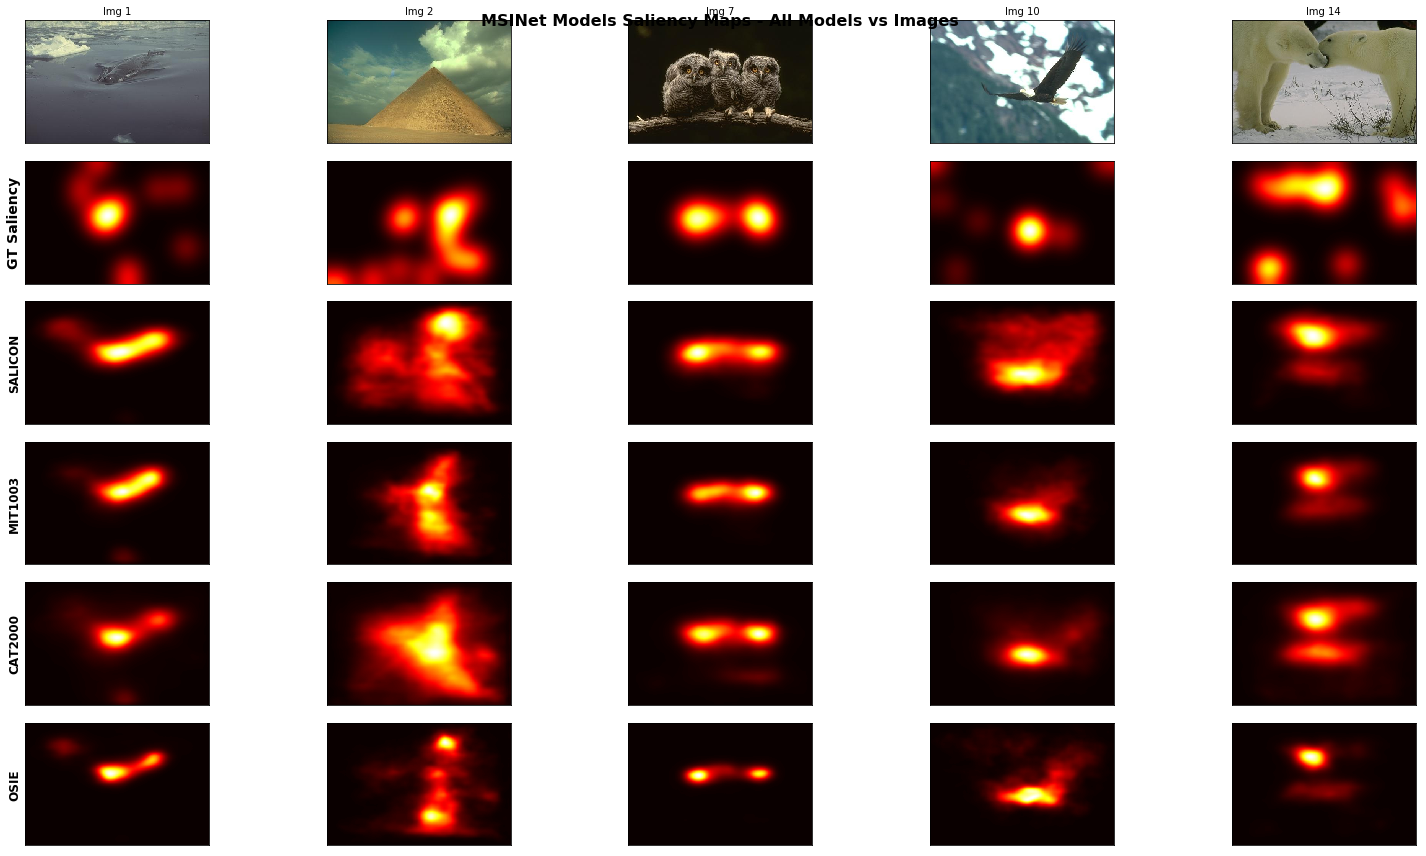

In [9]:
DISPLAY_IMAGES = [1, 2, 7, 10, 14]
first_model = list(all_images.keys())[0]
first_images = [img for img in all_images[first_model] if img['Image'] in DISPLAY_IMAGES]

fig, axes = plt.subplots(len(all_images) + 2, len(DISPLAY_IMAGES), figsize=(22, 12))

for img_idx, img_data in enumerate(first_images):
    ax = axes[0, img_idx]
    ax.imshow(img_data['img'])
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_title(f"Img {img_data['Image']}", fontsize=10)

# GT Saliency maps
for img_idx, img_data in enumerate(first_images):
    ax = axes[1, img_idx]
    ax.imshow(img_data['salmap_gt'], cmap='hot')
    ax.set_xticks([])
    ax.set_yticks([])
    if img_idx == 0:
        ax.set_ylabel("GT Saliency", fontsize=14, fontweight='bold')

# Model saliency maps
for model_idx, (model_name, images_list) in enumerate(all_images.items()):
    filtered_images = [img for img in images_list if img['Image'] in DISPLAY_IMAGES]
    for img_idx, img_data in enumerate(filtered_images):
        ax = axes[model_idx + 2, img_idx]
        ax.imshow(img_data['salmap_msinet'], cmap='hot')
        ax.set_xticks([])
        ax.set_yticks([])
        
        if img_idx == 0:
            ax.set_ylabel(f"{model_name.upper()}", fontsize=12, fontweight='bold')

plt.suptitle('MSINet Models Saliency Maps - All Models vs Images', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

In [10]:
# Display results for each model
for model_name, results_msinet in all_results.items():
    results_msinet_df = pd.DataFrame(results_msinet)
    print(f"{model_name.upper()} Model Evaluation:")
    print(results_msinet_df.to_string())
    print(f"\nMean scores and standard deviations:")
    print(results_msinet_df[['AUC_Judd', 'CC', 'KL', 'SIM', 'NSS']].agg(['mean', 'std']))

print("Comparison of all models :")
comparison_data = []
for model_name, results_msinet in all_results.items():
    results_df = pd.DataFrame(results_msinet)
    comparison_data.append({
        'Model': model_name.upper(),
        'CC (mean)': f"{results_df['CC'].mean():.4f} ± {results_df['CC'].std():.4f}",
        'KL (mean)': f"{results_df['KL'].mean():.4f} ± {results_df['KL'].std():.4f}",
        'SIM (mean)': f"{results_df['SIM'].mean():.4f} ± {results_df['SIM'].std():.4f}",
        'NSS (mean)': f"{results_df['NSS'].mean():.4f} ± {results_df['NSS'].std():.4f}",
        'AUC_Judd (mean)': f"{results_df['AUC_Judd'].mean():.4f} ± {results_df['AUC_Judd'].std():.4f}"
    })
comparison_df = pd.DataFrame(comparison_data)
print(comparison_df.to_string(index=False))

SALICON Model Evaluation:
   Image  AUC_Judd        CC        KL       SIM       NSS
0      1  0.853897  0.585174  1.496001  0.509022  1.836814
1      2  0.726813  0.433044  0.962952  0.559600  0.568337
2      5  0.847511  0.941946  0.572453  0.765285  2.472252
3      7  0.963269  0.885197  0.170291  0.776896  3.156302
4     10  0.796257  0.697653  1.392023  0.517665  2.519744
5     14  0.720655  0.533131  1.949921  0.445790  1.024575
6     21  0.890247  0.833888  1.230702  0.611528  2.569747
7     27  0.819270  0.493473  1.044579  0.538664  1.127831
8     37  0.879039  0.782490  0.305885  0.717029  1.683513
9     44  0.619141  0.299938  1.001523  0.527287  0.536621

Mean scores and standard deviations:
      AUC_Judd        CC        KL       SIM       NSS
mean  0.811610  0.648593  1.012633  0.596877  1.749574
std   0.099783  0.212432  0.548741  0.116362  0.916378
MIT1003 Model Evaluation:
   Image  AUC_Judd        CC        KL       SIM       NSS
0      1  0.851521  0.512368  1.19036

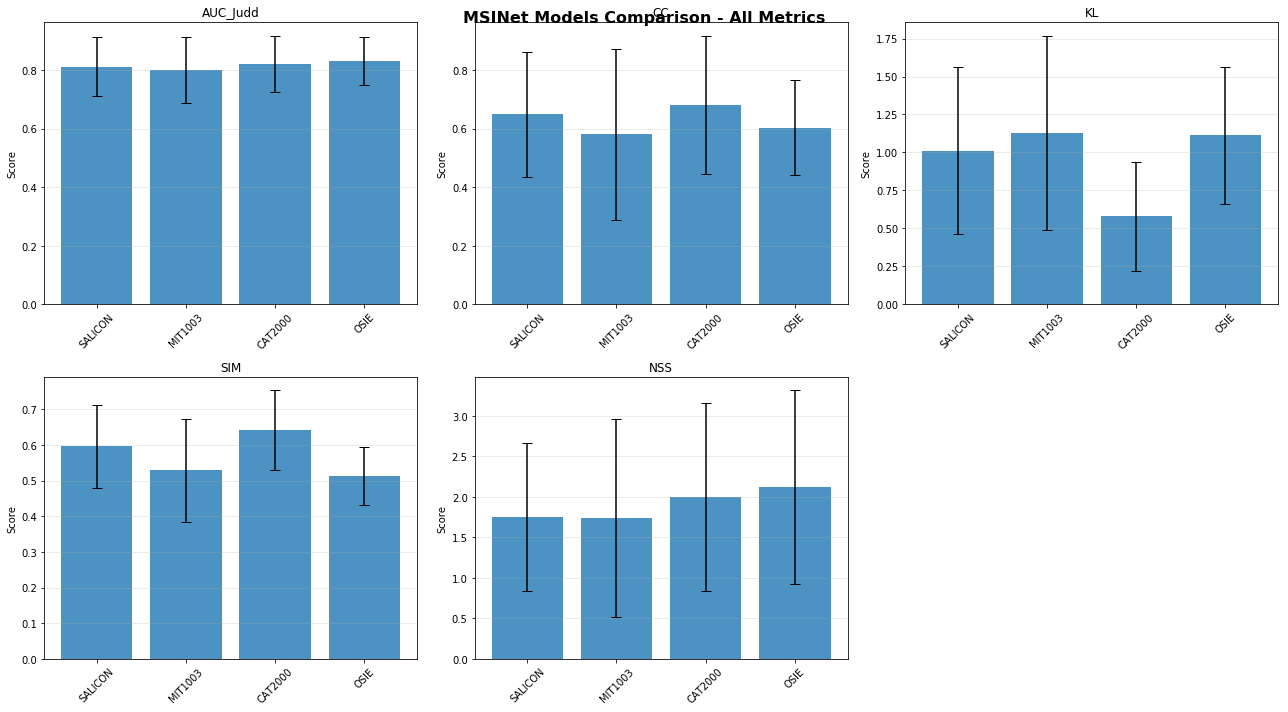

In [11]:
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
metrics = ['AUC_Judd', 'CC', 'KL', 'SIM', 'NSS']

for idx, metric in enumerate(metrics):
    ax = axes[idx // 3, idx % 3]
    
    means = []
    stds = []
    model_names = []
    
    for model_name in all_results.keys():
        results_df = pd.DataFrame(all_results[model_name])
        means.append(results_df[metric].mean())
        stds.append(results_df[metric].std())
        model_names.append(model_name.upper())
    
    x_pos = np.arange(len(model_names))
    ax.bar(x_pos, means, yerr=stds, capsize=5, alpha=0.8)
    ax.set_xticks(x_pos)
    ax.set_xticklabels(model_names, rotation=45)
    ax.set_ylabel('Score')
    ax.set_title(f'{metric}')
    ax.grid(True, alpha=0.3, axis='y')

axes[1, 2].remove()

plt.suptitle('MSINet Models Comparison - All Metrics', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

c:\Users\Marie\anaconda3\envs\msinet_saliency_env\lib\site-packages\matplotlib\cbook\__init__.py:1377: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x[:, None]
c:\Users\Marie\anaconda3\envs\msinet_saliency_env\lib\site-packages\matplotlib\axes\_base.py:239: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  y = y[:, np.newaxis]


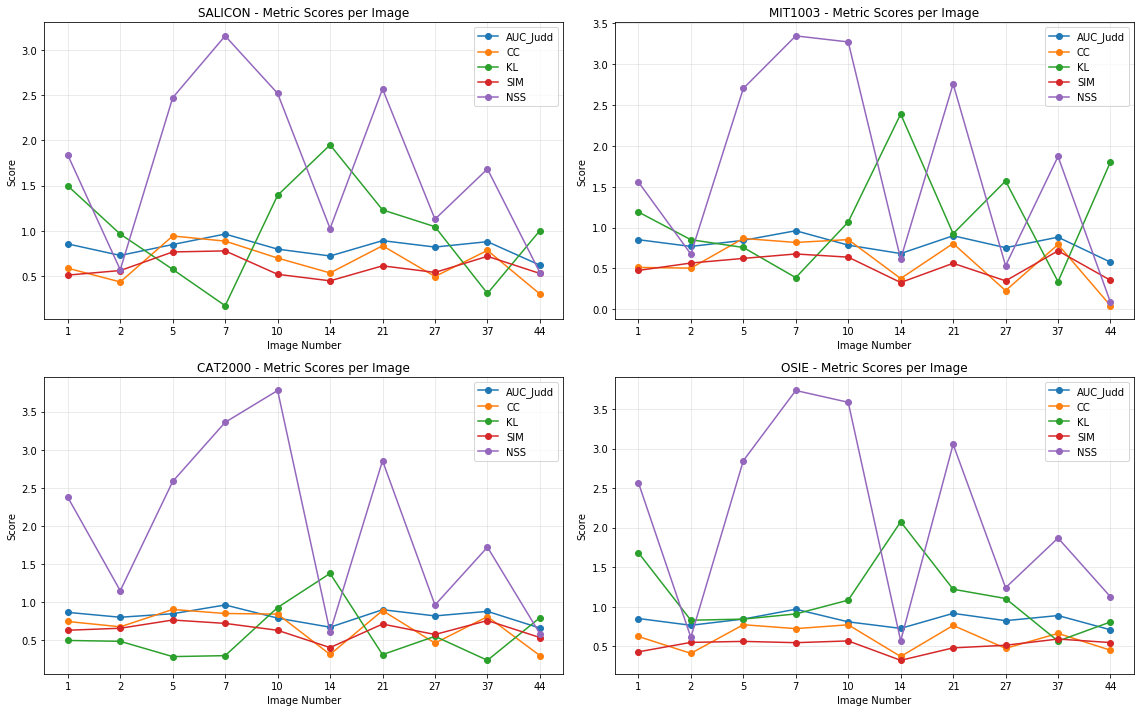

In [12]:
# All models
fig, axes = plt.subplots(2, 2, figsize=(16, 10))
axes = axes.flatten()

for idx, (model_name, results_msinet) in enumerate(all_results.items()):
    results_msinet_df = pd.DataFrame(results_msinet)
    ax = axes[idx]
    
    for metric in ['AUC_Judd', 'CC', 'KL', 'SIM', 'NSS']:
        x_pos = np.arange(len(results_msinet_df['Image']))
        ax.plot(x_pos, results_msinet_df[metric], marker='o', label=metric)
    
    ax.set_xlabel('Image Number')
    ax.set_ylabel('Score')
    ax.set_xticks(np.arange(len(results_msinet_df['Image'])))
    ax.set_xticklabels(results_msinet_df['Image'])
    ax.set_title(f"{model_name.upper()} - Metric Scores per Image")
    ax.legend()
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [13]:
#save
output_file = 'msinet_results_all_models.json'
results_dict = {}

for model_name, results_msinet in all_results.items():
    results_df = pd.DataFrame(results_msinet)
    results_dict[model_name] = [dict(row) for _, row in results_df.iterrows()]

with open(output_file, 'w') as f:
    json.dump(results_dict, f, indent=2)

print(f"saved {len(results_dict)} models {list(results_dict.keys())} to {output_file}")

saved 4 models ['salicon', 'mit1003', 'cat2000', 'osie'] to msinet_results_all_models.json


In [14]:
#Close
for model_name, sess in models_sessions.items():
    sess.close()
    print(f"{model_name.upper()} session closed")

SALICON session closed
MIT1003 session closed
CAT2000 session closed
OSIE session closed


### Analysis

For each metric, we can deduce the best model :

- CC (Correlation Coefficient): CAT2000 with 0.681 - Best correlation with human attention
- KL (KL Divergence): CAT2000 with 0.577 - Closest distribution (lower is better)
- SIM (Similarity): CAT2000 with 0.641 - Best spatial similarity
- NSS (Normalized Scanpath Saliency): OSIE with 2.120 - Best fixation prediction
- AUC_Judd: OSIE with 0.831 - Best fixation/non-fixation discrimination

Here CAT2000 seem to be the best, as it dominates on 3/5 metrics (CC, KL, SIM), and OSIE excels on NSS and AUC_Judd.

If we analyse modelby model, we have :

- CAT2000 :
  - Best overall correlation (CC = 0.681)
  - better distribution (KL = 0.577)
  - Good generalization to our dataset
  
- OSIE :
  - Good on fixation prediction (NSS = 2.120, AUC = 0.831)
  - Lower spatial similarity (SIM = 0.512)
  - Specialized but effective

- SALICON :
  - Balanced performance (CC = 0.649)
  - Moderate variance (std = 0.212)
  
- MIT1003 :
  - Lowest CC (0.580)
  - High variance (std = 0.293)
  - Training dataset too specific

Here, the models trained on diverse datasets (CAT2000, SALICON) outperform those trained on specific data (MIT1003). CAT2000 achieves better spatial correlation while OSIE excels at fixation detection. MIT1003 shows the highest variance (std CC = 0.293), indicating lower robustness. Training on web images (CAT2000, SALICON) transfers well to natural images from our dataset.